In [1]:
import pandas as pd
import numpy as np

In [26]:
cols_to_keep = ['primaryid', 'caseid', 'drug_seq',
                'role_cod', 'drugname', 'route',
                'origin', 'prod_ai', 'nda_num', 'val_vbm']

dtypes = {'primaryid': 'str',
          'caseid': 'str',
          'drug_seq': 'int8',
          'role_cod': 'str',
          'drugname': 'str',
          'route': 'str',
          'nda_num': 'str',
          'origin': 'str',
          'prod_ai': 'str',
          'val_vbm': 'int8'}

df_pd: pd.DataFrame = pd.read_csv("../data/processed/drug_table.csv",
                                      index_col=False,
                                      usecols=cols_to_keep,
                                      dtype=dtypes,
                                      low_memory=False)

In [69]:
len(df_pd)

40584418

# VAL VBM Experiments
check if all entries with  val_vbm = 1 (which means the trade name is validated) can actually map to the correct RxNorm drugname 100%. If this is the case, we can cut down significantly on our normalization experiment data size.

In [28]:
df_val: pd.DataFrame = df_pd[df_pd["val_vbm"] == 1]  #  subset of only validated trade names

In [34]:
unique_val_drugnames = df_val["drugname"].unique()

In [37]:
unique_val_drugnames

array(['SUSTIVA', 'NEVIRAPINE', 'VIRACEPT', ...,
       'ISOSORBIDE [ISOSORBIDE DINITRATE]', 'NEOMYCIN?POLY HC',
       'TARO?TERCONAZOLE'], dtype=object)

# Pre-processing of validated drug names:
- 1) Create subset of validated drugname dataframe that only looks at drugname related info (drugname, product active ing, nda)
- 2) Per row, count the frequency that these relevant values are missing
- 3) Add this new derived column to original dataframe
- 4) Sort by this new column, as to have the rows with the least missing info at the top
- 5) Drop all duplicates except for the first, as this will be the entry containing the most info (and hopefully the highest quality)

In [54]:
df_val_sub = df_val[["drugname", "prod_ai", "nda_num"]]
df_val_info_scores = df_val_sub.shape[1] - df_val_sub.count(axis=1)
df_val["info_scores"] = df_val_info_scores
df_val = df_val.sort_values(by=["info_scores"])
df_val_unique_first = df_val.drop_duplicates("drugname", keep="first")

In [67]:
len(df_val["drugname"].unique())

227679

In [64]:
df_val_unique_first.to_csv("../data/processed/validated_drugname_list.csv", index=False)

In [29]:
import dask.dataframe as dd

In [33]:
df = dd.read_csv("../data/processed/drug_table_clean.csv", dtype=dtypes)

In [34]:
df.isna().sum().compute()

primaryid           0
caseid              0
drug_seq            0
role_cod            4
drugname         1182
route        13209398
nda_num      26309522
origin              0
prod_ai       5833978
dtype: int64

In [37]:
df[df["drugname"].isna()].compute()

,primaryid,caseid,drug_seq,role_cod,drugname,route,nda_num,origin,prod_ai
9903,73348573,7334857,2,C,NaN,NaN,NaN,drug12q4.txt,NaN
249443,87910472,8791047,6,C,NaN,NaN,NaN,drug12q4.txt,NaN
763797,93000331,9300033,9,SS,NaN,NaN,NaN,drug12q4.txt,NaN
356531,95095111,9509511,7,C,NaN,NaN,NaN,DRUG13Q1.txt,NaN
915126,96839872,9683987,3,C,NaN,NaN,NaN,DRUG13Q4.txt,NaN
...,...,...,...,...,...,...,...,...,...
453456,190769841,19076984,2,C,NaN,NaN,NaN,DRUG21Q1.txt,UNSPECIFIED INGREDIENT
456526,190778351,19077835,2,C,NaN,NaN,NaN,DRUG21Q1.txt,UNSPECIFIED INGREDIENT
456639,190778731,19077873,2,C,NaN,NaN,NaN,DRUG21Q1.txt,UNSPECIFIED INGREDIENT
456751,190779081,19077908,2,C,NaN,NaN,NaN,DRUG21Q1.txt,UNSPECIFIED INGREDIENT


In [39]:
len(df["drugname"].unique().compute())

573151

In [41]:
len(df["primaryid"].unique().compute())

10711397

# Drugname entry statistics

In [93]:
val_drugnames = df_val["drugname"].unique().astype('str')

In [94]:
all_drugnames = df_pd["drugname"].unique().astype('str')

In [138]:
vbm_drugnames = df_pd[df_pd["val_vbm"] == 2]["drugname"].unique().astype('str')

In [97]:
all_drug_charlen = np.char.str_len(all_drugnames)

In [98]:
val_drug_charlen = np.char.str_len(val_drugnames)

In [140]:
vbm_drug_charlen = np.char.str_len(vbm_drugnames)

In [141]:
unique, counts = np.unique(all_drug_charlen, return_counts=True)
all_drug_dict = dict(zip(unique, counts))

unique, counts = np.unique(val_drug_charlen, return_counts=True)
val_drug_dict = dict(zip(unique, counts))

unique, counts = np.unique(vbm_drug_charlen, return_counts=True)
vbm_drug_dict = dict(zip(unique, counts))

In [142]:
len(vbm_drug_dict)

259

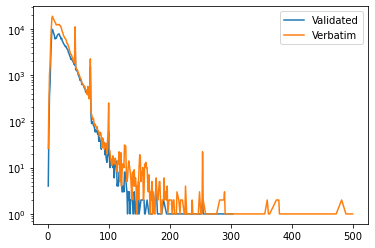

In [179]:
val_values = list(val_drug_dict.values())
all_values = list(all_drug_dict.values())
vbm_values = list(vbm_drug_dict.values())

validated_plot = plt.plot(val_drug_dict.keys(), val_values)
verbatim_plot = plt.plot(vbm_drug_dict.keys(), vbm_values)
plt.legend(labels=['Validated', 'Verbatim'])
plt.yscale("log")
plt.show()

In [167]:
from functools import wraps

def getstats(arr:np.ndarray):
    print(f"Max: {arr.max()}")
    print(f"Min: {arr.min()}")
    print(f"Mean: {arr.mean()}")
    print(f"Median: {np.median(arr)}")
    print(f"Stddev: {np.std(arr)}")


In [168]:
getstats(vbm_drug_charlen)

Max: 500
Min: 1
Mean: 21.99190316707978
Median: 18.0
Stddev: 15.760824697118773


In [169]:
getstats(val_drug_charlen)

Max: 304
Min: 1
Mean: 24.08138212131993
Median: 20.0
Stddev: 15.520199126779483


In [170]:
getstats(all_drug_charlen)

Max: 500
Min: 1
Mean: 22.94981427232963
Median: 19.0
Stddev: 15.808700704300334
